In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd

print(tf.__version__)
tf.random.set_seed(147)

2.9.2


In [3]:
path = '/content/drive/MyDrive/투자공학/기말과제'
X_data = pd.read_csv(path+'/re_train.csv')
y_data = pd.DataFrame(X_data['credit'])


## DNN

In [4]:
X_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12740 entries, 0 to 12739
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     12740 non-null  int64  
 1   credit         12740 non-null  int64  
 2   gender         12740 non-null  object 
 3   car            12740 non-null  object 
 4   reality        12740 non-null  object 
 5   child_num      12740 non-null  int64  
 6   income_total   12740 non-null  float64
 7   income_type    12740 non-null  object 
 8   edu_type       12740 non-null  object 
 9   family_type    12740 non-null  object 
 10  house_type     12740 non-null  object 
 11  DAYS_BIRTH     12740 non-null  int64  
 12  DAYS_EMPLOYED  12740 non-null  int64  
 13  FLAG_MOBIL     12740 non-null  int64  
 14  work_phone     12740 non-null  int64  
 15  phone          12740 non-null  int64  
 16  email          12740 non-null  int64  
 17  occyp_type     12740 non-null  object 
 18  family

In [5]:
y_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12740 entries, 0 to 12739
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   credit  12740 non-null  int64
dtypes: int64(1)
memory usage: 99.7 KB


In [6]:
def preprocessing(X_data):
    X_data = X_data.drop(['Unnamed: 0','credit','FLAG_MOBIL'], axis=1)
    X_data['gender'] = X_data['gender'].apply(lambda x: 0 if x == 'F' else 1)
    X_data['car'] = X_data['car'].apply(lambda x: 0 if x == 'N' else 1)
    X_data['reality'] = X_data['reality'].apply(lambda x: 0 if x == 'N' else 1)
    X_data = pd.get_dummies(X_data, prefix=['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type'])

    return X_data
    
X_data = preprocessing(X_data)
X_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12740 entries, 0 to 12739
Data columns (total 53 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   gender                                  12740 non-null  int64  
 1   car                                     12740 non-null  int64  
 2   reality                                 12740 non-null  int64  
 3   child_num                               12740 non-null  int64  
 4   income_total                            12740 non-null  float64
 5   DAYS_BIRTH                              12740 non-null  int64  
 6   DAYS_EMPLOYED                           12740 non-null  int64  
 7   work_phone                              12740 non-null  int64  
 8   phone                                   12740 non-null  int64  
 9   email                                   12740 non-null  int64  
 10  family_size                             12740 non-null  in

In [7]:
from sklearn.model_selection import train_test_split
train_X, valid_X, train_y, valid_y = train_test_split(X_data, y_data, test_size=0.3, stratify=y_data, random_state=1)

In [8]:
train_X.shape, valid_X.shape, train_y.shape, valid_y.shape

((8918, 53), (3822, 53), (8918, 1), (3822, 1))

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
valid_X = scaler.transform(valid_X)

In [10]:
from imblearn.over_sampling import SMOTE
train_X, train_y = SMOTE(random_state=0).fit_resample(train_X, train_y)
print(train_X.shape, train_y.shape)
train_y.value_counts()

(15630, 53) (15630, 1)


credit
0         7815
1         7815
dtype: int64

In [11]:
input_shape = train_X.shape[1]

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Dense(110, input_shape=(input_shape,), 
                                activation='relu'))

model.add(tf.keras.layers.Dense(220, activation='relu'))
model.add(tf.keras.layers.Dense(220, activation='relu'))
model.add(tf.keras.layers.Dense(110, activation='relu'))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dense(20, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='relu'))

model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 110)               5940      
                                                                 
 dense_1 (Dense)             (None, 220)               24420     
                                                                 
 dense_2 (Dense)             (None, 220)               48620     
                                                                 
 dense_3 (Dense)             (None, 110)               24310     
                                                                 
 dense_4 (Dense)             (None, 50)                5550      
                                                                 
 dense_5 (Dense)             (None, 20)                1020      
                                                                 
 dense_6 (Dense)             (None, 10)                2

In [12]:
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler

model.compile(tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='binary_crossentropy', metrics=['accuracy'])

rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, mode='max', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=20, mode='max', verbose=1, restore_best_weights=True)

In [13]:
hist = model.fit(train_X, train_y, epochs=10, validation_data=(valid_X, valid_y), callbacks=[rlr_cb, ely_cb])

Epoch 1/10
489/489 [==============================] - 8s 12ms/step - loss: 0.6456 - accuracy: 0.6200 - val_loss: 0.7019 - val_accuracy: 0.5931 - lr: 5.0000e-04
Epoch 2/10
489/489 [==============================] - 6s 11ms/step - loss: 0.5178 - accuracy: 0.7442 - val_loss: 0.5526 - val_accuracy: 0.7352 - lr: 5.0000e-04
Epoch 3/10
489/489 [==============================] - 6s 12ms/step - loss: 0.4182 - accuracy: 0.8048 - val_loss: 0.6649 - val_accuracy: 0.6931 - lr: 5.0000e-04
Epoch 4/10
489/489 [==============================] - 5s 9ms/step - loss: 0.3417 - accuracy: 0.8482 - val_loss: 0.6358 - val_accuracy: 0.7603 - lr: 5.0000e-04
Epoch 5/10
489/489 [==============================] - 3s 6ms/step - loss: 0.2969 - accuracy: 0.8720 - val_loss: 0.6257 - val_accuracy: 0.7718 - lr: 5.0000e-04
Epoch 6/10
489/489 [==============================] - 3s 5ms/step - loss: 0.2586 - accuracy: 0.8939 - val_loss: 0.6524 - val_accuracy: 0.7964 - lr: 5.0000e-04
Epoch 7/10
489/489 [=======================

In [14]:
# import matplotlib.pyplot as plt

# plt.plot(hist.history['accuracy'])
# plt.plot(hist.history['val_accuracy'])
# plt.title('Accuracy Trend')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train','validation'], loc='best')
# plt.grid()
# plt.show()

In [15]:
model.evaluate(valid_X, valid_y)

120/120 [==============================] - 0s 2ms/step - loss: 0.7486 - accuracy: 0.7959


[0.7485896944999695, 0.795918345451355]

In [16]:
test_predictions = model.predict(valid_X)
prediction = []
for pred in test_predictions:
  if pred > 0.5:
    prediction.append(1)
  else:
    prediction.append(0)
pd.value_counts(prediction)

120/120 [==============================] - 0s 2ms/step


1    3247
0     575
dtype: int64

Accuracy: 0.7959183673469388


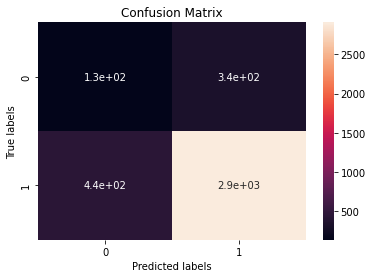

In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt   

cm = confusion_matrix(valid_y, prediction)
print('Accuracy:', accuracy_score(valid_y, prediction))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

## Test data Prediction

In [18]:
X_test = pd.read_csv(path+'/test_data.csv')
y_test = pd.read_csv(path+'/test/test_label.csv')


In [19]:
X_test = X_test.drop(['Unnamed: 0'], axis=1)
X_test['gender'] = X_test['gender'].apply(lambda x: 0 if x == 'F' else 1)
X_test['car'] = X_test['car'].apply(lambda x: 0 if x == 'N' else 1)
X_test['reality'] = X_test['reality'].apply(lambda x: 0 if x == 'N' else 1)
X_data = pd.get_dummies(X_test, columns=['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type'])
X_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13229 entries, 0 to 13228
Data columns (total 53 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   gender                                  13229 non-null  int64  
 1   car                                     13229 non-null  int64  
 2   reality                                 13229 non-null  int64  
 3   child_num                               13229 non-null  int64  
 4   income_total                            13229 non-null  float64
 5   DAYS_BIRTH                              13229 non-null  int64  
 6   DAYS_EMPLOYED                           13229 non-null  int64  
 7   work_phone                              13229 non-null  int64  
 8   phone                                   13229 non-null  int64  
 9   email                                   13229 non-null  int64  
 10  family_size                             13229 non-null  in

In [20]:
X_data = scaler.transform(X_data)

In [21]:
test_predictions = model.predict(X_data)
prediction = []
for pred in test_predictions:
  if pred > 0.5:
    prediction.append(1)
  else:
    prediction.append(0)
pd.value_counts(prediction)

414/414 [==============================] - 1s 2ms/step


1    11294
0     1935
dtype: int64

In [22]:
y_test['credit'] = prediction
y_test = y_test.drop(['index'], axis=1)
y_test.to_csv('test_label.csv')

## DNN With Clustered Data

In [23]:
X_cluster = pd.read_csv(path+'/cluster.csv')
X_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12740 entries, 0 to 12739
Data columns (total 58 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Unnamed: 0                              12740 non-null  int64  
 1   child_num                               12740 non-null  int64  
 2   income_total                            12740 non-null  float64
 3   DAYS_BIRTH                              12740 non-null  int64  
 4   DAYS_EMPLOYED                           12740 non-null  int64  
 5   family_size                             12740 non-null  int64  
 6   begin_month                             12740 non-null  int64  
 7   gender                                  12740 non-null  int64  
 8   car                                     12740 non-null  int64  
 9   reality                                 12740 non-null  int64  
 10  work_phone                              12740 non-null  in

In [24]:
X_cluster.head()

,Unnamed: 0,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,family_size,begin_month,gender,car,reality,...,occyp_type_Realty agents,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Unknown,occyp_type_Waiters/barmen staff,cluster_label_0,cluster_label_1,cluster_label_2,cluster_label_3
0,0,0,202500.0,-19031,1,2,-53,1,1,1,...,0,0,0,0,0,0,0,0,1,0
1,1,1,157500.0,-15773,-309,3,-26,1,1,1,...,0,1,0,0,0,0,0,0,0,1
2,2,0,135000.0,-13483,-1816,2,-9,1,1,1,...,0,0,0,0,0,0,1,0,0,0
3,3,2,112500.0,-12270,-150,4,-12,1,1,1,...,0,0,0,1,0,0,0,0,0,1
4,4,1,225000.0,-16175,-2371,3,-3,1,1,1,...,0,0,0,0,0,0,0,0,0,1


In [25]:
train_X, valid_X, train_y, valid_y = train_test_split(X_cluster, y_data, test_size=0.3, stratify=y_data, random_state=1)
train_X.shape, valid_X.shape, train_y.shape, valid_y.shape

((8918, 58), (3822, 58), (8918, 1), (3822, 1))

In [26]:
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
valid_X = scaler.transform(valid_X)

In [27]:
train_X, train_y = SMOTE(random_state=0).fit_resample(train_X, train_y)
print(train_X.shape, train_y.shape)
train_y.value_counts()

(15630, 58) (15630, 1)


credit
0         7815
1         7815
dtype: int64

In [28]:
input_shape = train_X.shape[1]

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Dense(110, input_shape=(input_shape,), 
                                activation='relu'))

model.add(tf.keras.layers.Dense(220, activation='relu'))
model.add(tf.keras.layers.Dense(220, activation='relu'))
model.add(tf.keras.layers.Dense(110, activation='relu'))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dense(20, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='relu'))

model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 110)               6490      
                                                                 
 dense_9 (Dense)             (None, 220)               24420     
                                                                 
 dense_10 (Dense)            (None, 220)               48620     
                                                                 
 dense_11 (Dense)            (None, 110)               24310     
                                                                 
 dense_12 (Dense)            (None, 50)                5550      
                                                                 
 dense_13 (Dense)            (None, 20)                1020      
                                                                 
 dense_14 (Dense)            (None, 10)               

In [29]:
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler

model.compile(tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='binary_crossentropy', metrics=['accuracy'])

rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, mode='max', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=20, mode='max', verbose=1, restore_best_weights=True)

In [30]:
hist = model.fit(train_X, train_y, epochs=10, validation_data=(valid_X, valid_y), callbacks=[rlr_cb, ely_cb])

Epoch 1/10
489/489 [==============================] - 4s 6ms/step - loss: 0.6566 - accuracy: 0.5932 - val_loss: 0.7181 - val_accuracy: 0.5390 - lr: 5.0000e-04
Epoch 2/10
489/489 [==============================] - 3s 6ms/step - loss: 0.5458 - accuracy: 0.7161 - val_loss: 0.5752 - val_accuracy: 0.7166 - lr: 5.0000e-04
Epoch 3/10
489/489 [==============================] - 3s 5ms/step - loss: 0.4351 - accuracy: 0.7927 - val_loss: 0.6447 - val_accuracy: 0.7104 - lr: 5.0000e-04
Epoch 4/10
489/489 [==============================] - 3s 5ms/step - loss: 0.3587 - accuracy: 0.8379 - val_loss: 0.6855 - val_accuracy: 0.7554 - lr: 5.0000e-04
Epoch 5/10
489/489 [==============================] - 3s 5ms/step - loss: 0.3069 - accuracy: 0.8653 - val_loss: 0.7302 - val_accuracy: 0.7284 - lr: 5.0000e-04
Epoch 6/10
489/489 [==============================] - 3s 6ms/step - loss: 0.2670 - accuracy: 0.8861 - val_loss: 0.7067 - val_accuracy: 0.7862 - lr: 5.0000e-04
Epoch 7/10
489/489 [==========================

In [31]:
model.evaluate(valid_X, valid_y)

120/120 [==============================] - 0s 3ms/step - loss: 0.9453 - accuracy: 0.7554


[0.9453187584877014, 0.7553637027740479]

In [32]:
test_predictions = model.predict(valid_X)
prediction = []
for pred in test_predictions:
  if pred > 0.5:
    prediction.append(1)
  else:
    prediction.append(0)
pd.value_counts(prediction)

120/120 [==============================] - 0s 3ms/step


1    3098
0     724
dtype: int64

Accuracy: 0.7553636839351126


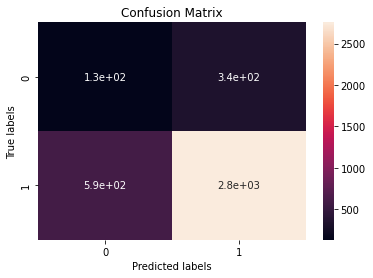

In [33]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt   

cm = confusion_matrix(valid_y, prediction)
print('Accuracy:', accuracy_score(valid_y, prediction))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

## DNN With SOM data

In [34]:
X_som = pd.read_csv(path+'/som_df.csv')
X_som = X_som.drop(['Unnamed: 0', 'credit'], axis=1)
X_som.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12740 entries, 0 to 12739
Data columns (total 37 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   income_total                            12740 non-null  float64
 1   child_num                               12740 non-null  int64  
 2   family_size                             12740 non-null  int64  
 3   gender_F                                12740 non-null  int64  
 4   gender_M                                12740 non-null  int64  
 5   car_N                                   12740 non-null  int64  
 6   car_Y                                   12740 non-null  int64  
 7   income_type_Commercial associate        12740 non-null  int64  
 8   income_type_Pensioner                   12740 non-null  int64  
 9   income_type_State servant               12740 non-null  int64  
 10  income_type_Student                     12740 non-null  in

In [35]:
train_X, valid_X, train_y, valid_y = train_test_split(X_som, y_data, test_size=0.3, stratify=y_data, random_state=1)
train_X.shape, valid_X.shape, train_y.shape, valid_y.shape
train_X.shape, valid_X.shape, train_y.shape, valid_y.shape

((8918, 37), (3822, 37), (8918, 1), (3822, 1))

In [36]:
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
valid_X = scaler.transform(valid_X)

In [37]:
train_X, train_y = SMOTE(random_state=0).fit_resample(train_X, train_y)
print(train_X.shape, train_y.shape)
train_y.value_counts()

(15630, 37) (15630, 1)


credit
0         7815
1         7815
dtype: int64

In [38]:
input_shape = train_X.shape[1]

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Dense(110, input_shape=(input_shape,), 
                                activation='relu'))

model.add(tf.keras.layers.Dense(220, activation='relu'))
model.add(tf.keras.layers.Dense(220, activation='relu'))
model.add(tf.keras.layers.Dense(110, activation='relu'))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dense(20, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='relu'))

model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 110)               4180      
                                                                 
 dense_17 (Dense)            (None, 220)               24420     
                                                                 
 dense_18 (Dense)            (None, 220)               48620     
                                                                 
 dense_19 (Dense)            (None, 110)               24310     
                                                                 
 dense_20 (Dense)            (None, 50)                5550      
                                                                 
 dense_21 (Dense)            (None, 20)                1020      
                                                                 
 dense_22 (Dense)            (None, 10)               

In [39]:
model.compile(tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy', metrics=['accuracy'])

rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, mode='max', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=20, mode='max', verbose=1, restore_best_weights=True)

In [40]:
hist = model.fit(train_X, train_y, epochs=10, validation_data=(valid_X, valid_y), callbacks=[rlr_cb, ely_cb])

Epoch 1/10
489/489 [==============================] - 4s 6ms/step - loss: 0.6905 - accuracy: 0.5223 - val_loss: 0.7301 - val_accuracy: 0.3472 - lr: 0.0010
Epoch 2/10
489/489 [==============================] - 3s 6ms/step - loss: 0.6668 - accuracy: 0.5807 - val_loss: 0.6415 - val_accuracy: 0.5552 - lr: 0.0010
Epoch 3/10
489/489 [==============================] - 3s 6ms/step - loss: 0.6291 - accuracy: 0.6328 - val_loss: 0.6292 - val_accuracy: 0.5484 - lr: 0.0010
Epoch 4/10
489/489 [==============================] - 3s 5ms/step - loss: 0.5954 - accuracy: 0.6624 - val_loss: 0.6937 - val_accuracy: 0.5194 - lr: 0.0010
Epoch 5/10
489/489 [==============================] - 3s 5ms/step - loss: 0.5669 - accuracy: 0.6854 - val_loss: 0.6608 - val_accuracy: 0.5808 - lr: 0.0010
Epoch 6/10
489/489 [==============================] - 3s 6ms/step - loss: 0.5390 - accuracy: 0.7061 - val_loss: 0.6477 - val_accuracy: 0.6361 - lr: 0.0010
Epoch 7/10
489/489 [==============================] - 3s 6ms/step - lo

In [41]:
model.evaluate(valid_X, valid_y)

120/120 [==============================] - 0s 2ms/step - loss: 0.7230 - accuracy: 0.6722


[0.7230470180511475, 0.6721611618995667]

In [42]:
test_predictions = model.predict(valid_X)
prediction = []
for pred in test_predictions:
  if pred > 0.5:
    prediction.append(1)
  else:
    prediction.append(0)
pd.value_counts(prediction)

120/120 [==============================] - 0s 2ms/step


1    2626
0    1196
dtype: int64

Accuracy: 0.6721611721611722


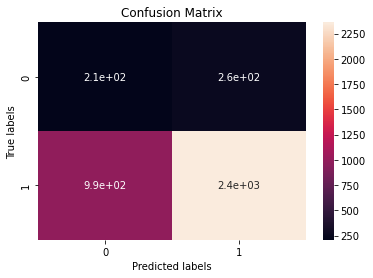

In [43]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt   

cm = confusion_matrix(valid_y, prediction)
print('Accuracy:', accuracy_score(valid_y, prediction))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 